In [1]:
# !pip install gdown
# !pip install -U scikit-learn
# !pip install imbalanced-learn
# !pip install seaborn

In [2]:
from utils.Util import *
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transform
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import cv2 as cv
from zipfile import ZipFile
import gdown
from models.CNNSimple import CNNSimple
from models.CNNResNet import CNNResNet
from models.CNNSmall import CNNSmall
from models.Model import Model

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

/home/jorge/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_set_url = 'https://drive.google.com/uc?id=1hILStd3NReX_y8GgNVs9YEN2Y6_8HNpd'
file = 'archive2.zip'

In [4]:
#Descargar y extraer si no existe el archivo.
if not os.path.exists(file):
    gdown.download(data_set_url, file, quiet=False)
    with ZipFile('archive2.zip', 'r') as zipObj:
        zipObj.extractall(path='./data') 

In [5]:
DIR = './data/dataset'
RESIZE = (140,140)
CLASES = os.listdir(DIR)
BATCH_SIZE = 16
LEN_CLASES = len(CLASES)
print(CLASES)
print(LEN_CLASES)


['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
11


In [6]:
#Resie all images
trans = transform.Compose([
    transform.Resize(RESIZE),
    transform.ToTensor()
])

In [7]:
dataset = ImageFolder(DIR,transform=trans)

In [8]:
image,label = dataset[0]
print(image.shape)
print(len(dataset))

torch.Size([3, 140, 140])
6862


Label:  dew (0)


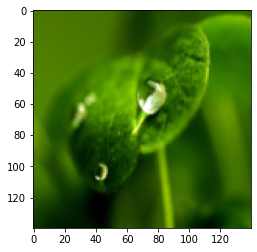

In [9]:
show_example(*dataset[0],dataset)

In [10]:
random_seed = 34
torch.manual_seed(random_seed)


In [11]:
LEN_DATASET = len(dataset)
LEN_TRAIN_SET = round(LEN_DATASET*0.8)
LEN_VALIDATION_SET = round(LEN_DATASET*0.1)
LEN_TEST_SET = round(LEN_DATASET*0.1)
print(LEN_DATASET)
print(LEN_TRAIN_SET,LEN_VALIDATION_SET,LEN_TEST_SET)

6862
5490 686 686


In [12]:
#Normalizar los datos
MEAN, DS = get_mean_and_std(DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True))

In [13]:
normalize_compose = transform.Compose([
    transform.Resize(RESIZE),
    transform.ToTensor(),
    transform.Normalize(MEAN, DS, inplace=False),
])

In [14]:
dataset = ImageFolder(DIR, transform=normalize_compose)

In [15]:
TRAIN_DATA, TEST_DATA,VALID_DATA = random_split(dataset, [LEN_TRAIN_SET, LEN_VALIDATION_SET,LEN_TEST_SET])

In [16]:
dist_train = [ x[1] for x in TRAIN_DATA]
dist_test = [ x[1] for x in TEST_DATA]
dist_valid = [ x[1] for x in VALID_DATA]



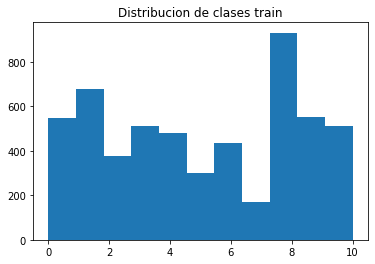

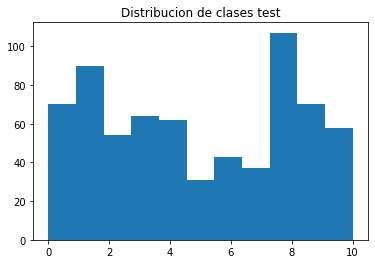

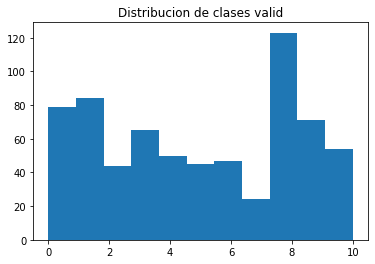

In [17]:
plt.hist(dist_train,bins=LEN_CLASES)
plt.title('Distribucion de clases train')
plt.show()
plt.hist(dist_test,bins=LEN_CLASES)
plt.title('Distribucion de clases test')
plt.show()
plt.hist(dist_valid,bins=LEN_CLASES)
plt.title('Distribucion de clases valid')
plt.show()

In [18]:
TRAIN_DL = DataLoader(TRAIN_DATA, batch_size=BATCH_SIZE, shuffle=True)
VALID_DL = DataLoader(VALID_DATA, batch_size=BATCH_SIZE, shuffle=True)
TEST_DL = DataLoader(TEST_DATA, batch_size=BATCH_SIZE, shuffle=True)

16
16


/home/jorge/Documentos/utec/ciclo7/ia/proyectoIA3/utils/Util.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means = torch.tensor(measn).reshape(1,3,1,1)
/home/jorge/Documentos/utec/ciclo7/ia/proyectoIA3/utils/Util.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stds = torch.tensor(std).reshape(1,3,1,1)


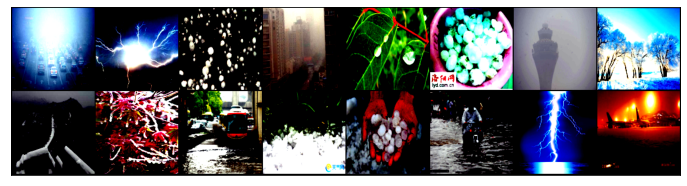

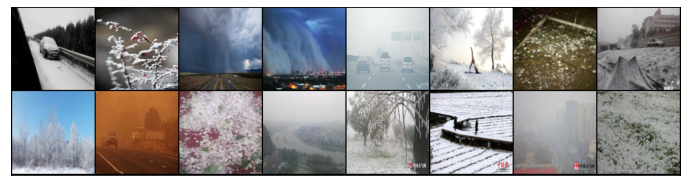

In [19]:
show_batch(TRAIN_DL)
show_batch_denormalize(TRAIN_DL,MEAN,DS)

In [20]:
device = get_default_device()
print(device)

cuda


In [21]:
TRAIN_DEVICE_DL = DeviceDataLoader(TRAIN_DL, device)
VALID_DEVICE_DL = DeviceDataLoader(VALID_DL, device)
TEST_DEVICE_DL = DeviceDataLoader(TEST_DL, device)

In [22]:
learning_rate =  0.001
num_epochs = 20
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam

# Tiny Model CNN (3 CONV LAYERS + LINEAR LAYER)

In [23]:
#MODELO Tiny CNN
modeloSmall = to_device(CNNSmall(LEN_CLASES), device)

In [24]:
modeloSmall.load_state_dict(torch.load('db/cnnSmall.pth'))

<All keys matched successfully>

In [25]:
smodel = Model(modeloSmall)
smodel.evaluate(TRAIN_DEVICE_DL)

{'error': 0.27568960189819336, 'acc': 0.9084302186965942}

In [26]:
#logSmall = smodel.train(optimizer,loss_fn,num_epochs,TRAIN_DEVICE_DL,VALID_DEVICE_DL,learning_rate)

In [27]:
#plot_losses(logSmall)

# Result for TRAIN DATASET

Error: 0.2757629156112671 Accuracy: 0.9084302186965942


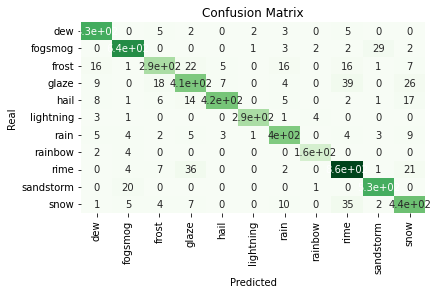

Sensitivity
90.82
Specificity
99.08
F1-score
90.82
Accuracy
90.82


In [28]:
smodelResTrain = smodel.evaluate(TRAIN_DEVICE_DL,True)
print("Error:",smodelResTrain['error'], "Accuracy:",smodelResTrain['acc'])
MatrixScore(smodelResTrain['outputs']['labels'],smodelResTrain['outputs']['predicted'],CLASES)

# Result for VALIDATION DATASET

Error: 0.8435531258583069 Accuracy: 0.7641196250915527


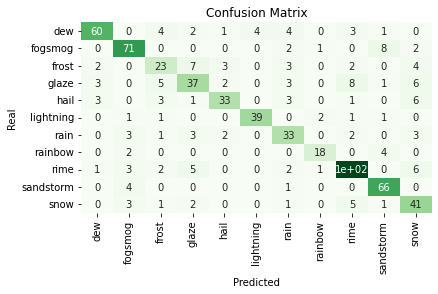

Sensitivity
76.38
Specificity
97.64
F1-score
76.38
Accuracy
76.38


In [29]:
smodelResValid = smodel.evaluate(VALID_DEVICE_DL,True)
print("Error:",smodelResValid['error'], "Accuracy:",smodelResValid['acc'])
MatrixScore(smodelResValid['outputs']['labels'],smodelResValid['outputs']['predicted'],CLASES)

# Result for TEST DATASET

Error: 0.6105522513389587 Accuracy: 0.8044019937515259


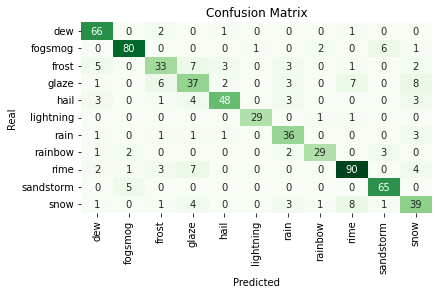

Sensitivity
80.47
Specificity
98.05
F1-score
80.47
Accuracy
80.47


In [30]:
smodelResTest = smodel.evaluate(TEST_DEVICE_DL,True)
print("Error:",smodelResTest['error'], "Accuracy:",smodelResTest['acc'])
MatrixScore(smodelResTest['outputs']['labels'],smodelResTest['outputs']['predicted'],CLASES)


In [31]:
#guardamos el modelo
#torch.save(modeloSmall.state_dict(), 'db/cnnSmall.pth')

#  Simple Model CNN (5 LAYERS + 1 LINEAR)

In [32]:
modeloSimple = to_device(CNNSimple(LEN_CLASES), device)

In [34]:
modeloSimple.load_state_dict(torch.load('db/cnnSimple.pth'))

<All keys matched successfully>

In [ ]:
simModel = Model(modeloSimple)
simModel.evaluate(TRAIN_DEVICE_DL)

In [ ]:
#logSimple = simModel.train(optimizer,loss_fn,num_epochs,TRAIN_DEVICE_DL,VALID_DEVICE_DL,learning_rate)

Epoch [1/20],Loss Train 1.5399,val_loss:1.2839,Accuracy 0.5818
Epoch [2/20],Loss Train 1.2122,val_loss:1.0051,Accuracy 0.6541
Epoch [3/20],Loss Train 1.0769,val_loss:0.9987,Accuracy 0.6547
Epoch [4/20],Loss Train 1.0083,val_loss:0.9366,Accuracy 0.6840
Epoch [5/20],Loss Train 0.9244,val_loss:0.8814,Accuracy 0.7155
Epoch [6/20],Loss Train 0.8826,val_loss:0.8189,Accuracy 0.7390
Epoch [7/20],Loss Train 0.8312,val_loss:0.8294,Accuracy 0.7392
Epoch [8/20],Loss Train 0.7464,val_loss:1.0157,Accuracy 0.6956
Epoch [9/20],Loss Train 0.7394,val_loss:0.8668,Accuracy 0.7317
Epoch [10/20],Loss Train 0.6834,val_loss:0.7714,Accuracy 0.7523
Epoch [11/20],Loss Train 0.6407,val_loss:0.7526,Accuracy 0.7598
Epoch [12/20],Loss Train 0.6240,val_loss:0.8365,Accuracy 0.7452
Epoch [13/20],Loss Train 0.5757,val_loss:0.7601,Accuracy 0.7801
Epoch [14/20],Loss Train 0.5423,val_loss:0.8050,Accuracy 0.7521
Epoch [15/20],Loss Train 0.4896,val_loss:0.7694,Accuracy 0.7919
Epoch [16/20],Loss Train 0.4602,val_loss:0.9109,A

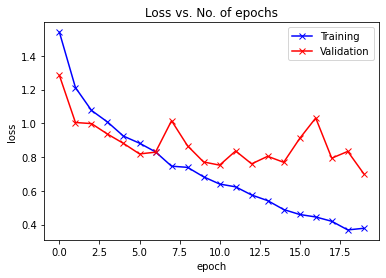

In [ ]:
#plot_losses(logSimple)

# Result for TRAIN DATASET

Error: 0.18444865942001343 Accuracy: 0.9358648061752319


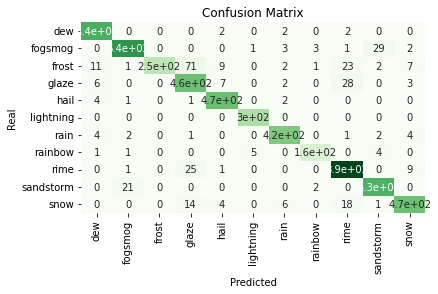

Sensitivity
93.57
Specificity
99.36
F1-score
93.57
Accuracy
93.57


In [ ]:
simModelResTrain = simModel.evaluate(TRAIN_DEVICE_DL,True)
print("Error:",simModelResTrain['error'], "Accuracy:",simModelResTrain['acc'])
MatrixScore(simModelResTrain['outputs']['labels'],simModelResTrain['outputs']['predicted'],CLASES)

# Result for VALIDATION DATASET

Error: 0.7016301155090332 Accuracy: 0.8050249814987183


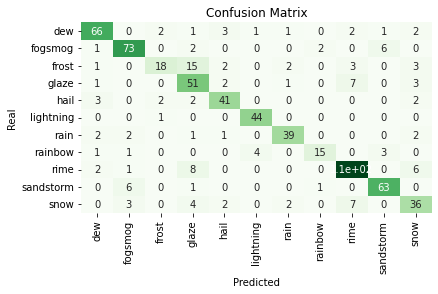

Sensitivity
80.47
Specificity
98.05
F1-score
80.47
Accuracy
80.47


In [ ]:
simModelResValid = simModel.evaluate(VALID_DEVICE_DL,True)
print("Error:",simModelResValid['error'], "Accuracy:",simModelResValid['acc'])
MatrixScore(simModelResValid['outputs']['labels'],simModelResValid['outputs']['predicted'],CLASES)

# Result for TEST DATASET

Error: 0.6806864142417908 Accuracy: 0.7942276000976562


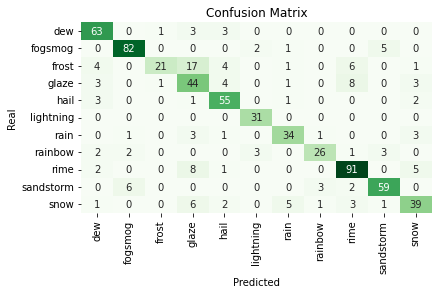

Sensitivity
79.45
Specificity
97.94
F1-score
79.45
Accuracy
79.45


In [ ]:
simModelResTest = simModel.evaluate(TEST_DEVICE_DL,True)
print("Error:",simModelResTest['error'], "Accuracy:",simModelResTest['acc'])
MatrixScore(simModelResTest['outputs']['labels'],simModelResTest['outputs']['predicted'],CLASES)


In [ ]:
#guardamos el modelo
#torch.save(modeloSimple.state_dict(), 'db/cnnSimple.pth')

#  ResNet Model CNN (8 LAYERS + 1 LINEAR)

In [36]:
modeloResnet = to_device(CNNResNet(LEN_CLASES), device)

In [ ]:
modeloResnet.load_state_dict(torch.load('db/cnnResNet.pth'))

In [37]:
ResNetModel = Model(modeloResnet)
ResNetModel.evaluate(TRAIN_DEVICE_DL)

{'error': 2.393789291381836, 'acc': 0.11101017147302628}

In [38]:
# %%time
# logResnet = ResNetModel.train(optimizer,loss_fn,num_epochs,TRAIN_DEVICE_DL,VALID_DEVICE_DL,learning_rate)

Epoch [1/20],Loss Train 1.4034,val_loss:1.1947,Accuracy 0.6140
Epoch [2/20],Loss Train 1.0551,val_loss:1.0530,Accuracy 0.6605
Epoch [3/20],Loss Train 0.9120,val_loss:0.9096,Accuracy 0.7010
Epoch [4/20],Loss Train 0.7769,val_loss:0.7739,Accuracy 0.7604
Epoch [5/20],Loss Train 0.6783,val_loss:0.9024,Accuracy 0.7276
Epoch [6/20],Loss Train 0.6070,val_loss:0.8191,Accuracy 0.7417
Epoch [7/20],Loss Train 0.5034,val_loss:0.7710,Accuracy 0.7654
Epoch [8/20],Loss Train 0.5311,val_loss:0.7671,Accuracy 0.7787
Epoch [9/20],Loss Train 0.3808,val_loss:0.8568,Accuracy 0.7427
Epoch [10/20],Loss Train 0.3139,val_loss:0.7124,Accuracy 0.7753
Epoch [11/20],Loss Train 0.3363,val_loss:0.7007,Accuracy 0.7973
Epoch [12/20],Loss Train 0.2756,val_loss:0.7302,Accuracy 0.8002
Epoch [13/20],Loss Train 0.1926,val_loss:0.7827,Accuracy 0.7710
Epoch [14/20],Loss Train 0.1648,val_loss:0.7364,Accuracy 0.8075
Epoch [15/20],Loss Train 0.1733,val_loss:0.8596,Accuracy 0.7728
Epoch [16/20],Loss Train 0.1729,val_loss:0.7490,A

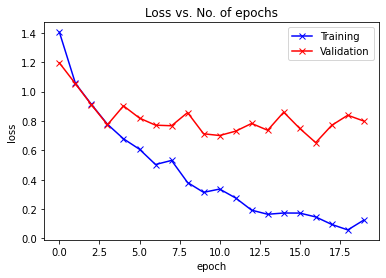

In [39]:
# plot_losses(logResnet)

# Result for TRAIN DATASET

Error: 0.030236653983592987 Accuracy: 0.9910973906517029


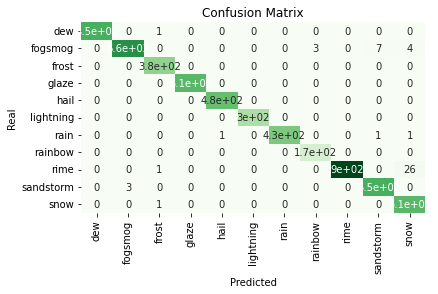

Sensitivity
99.11
Specificity
99.91
F1-score
99.11
Accuracy
99.11


In [40]:
ResNetModelResTrain = ResNetModel.evaluate(TRAIN_DEVICE_DL,True)
print("Error:",ResNetModelResTrain['error'], "Accuracy:",ResNetModelResTrain['acc'])
MatrixScore(ResNetModelResTrain['outputs']['labels'],ResNetModelResTrain['outputs']['predicted'],CLASES)

# Result for VALIDATION DATASET

Error: 0.7981340289115906 Accuracy: 0.8075165748596191


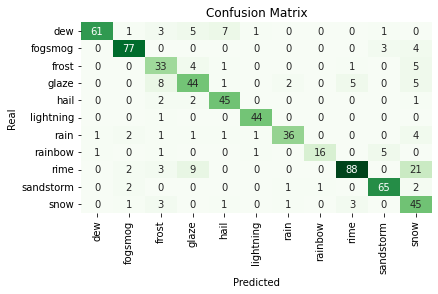

Sensitivity
80.76
Specificity
98.08
F1-score
80.76
Accuracy
80.76


In [41]:
ResNetModelResValid = ResNetModel.evaluate(VALID_DEVICE_DL,True)
print("Error:",ResNetModelResValid['error'], "Accuracy:",ResNetModelResValid['acc'])
MatrixScore(ResNetModelResValid['outputs']['labels'],ResNetModelResValid['outputs']['predicted'],CLASES)

# Result for TEST DATASET

Error: 0.6054518818855286 Accuracy: 0.8455149531364441


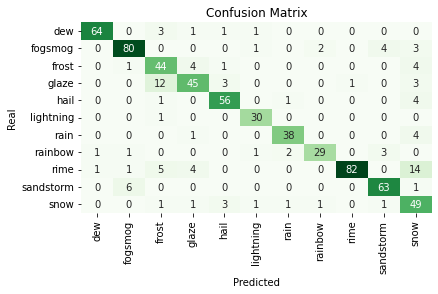

Sensitivity
84.55
Specificity
98.45
F1-score
84.55
Accuracy
84.55


In [42]:
ResNetModelResTest = ResNetModel.evaluate(TEST_DEVICE_DL,True)
print("Error:",ResNetModelResTest['error'], "Accuracy:",ResNetModelResTest['acc'])
MatrixScore(ResNetModelResTest['outputs']['labels'],ResNetModelResTest['outputs']['predicted'],CLASES)


In [43]:
#guardamos el modelo
torch.save(modeloResnet.state_dict(), 'db/cnnResNet.pth')